In [24]:
%load_ext autoreload
%autoreload 2

import subprocess
from pathlib import Path
import numpy as np
import ruamel.yaml as yaml
import torch
from easydict import EasyDict as edict
from torchvision.utils import make_grid, save_image
from matplotlib import pyplot as plt
from PIL import Image

from ex2mcmc.gan_distribution import Distribution, DistributionRegistry
from ex2mcmc.models.rnvp_minimal import RealNVPProposal
from ex2mcmc.models.utils import GANWrapper
from ex2mcmc.fid_sample import Sampler
from ex2mcmc.utils.callbacks import CallbackRegistry
from ex2mcmc.utils.general_utils import DotConfig, PROJECT_PATH, LOG_DIR, IMGS_DIR

# from ex2mcmc.utils.metrics.compute_fid_tf import calculate_fid_given_paths
# from ex2mcmc.utils.metrics.inception_score import (
#     MEAN_TRASFORM,
#     N_GEN_IMAGES,
#     STD_TRANSFORM,
#     get_inception_score,
# )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def define_sampler(
    config: DotConfig,
    gan: GANWrapper,
    ref_dist: Distribution,
    save_dir: Path,
):
    sampler_callbacks = []
    callbacks = config.callbacks.sampler_callbacks
    if callbacks:
        for _, callback in callbacks.items():
            params = callback.params.dict
            # HACK
            if "save_dir" in params:
                params["save_dir"] = save_dir
            sampler_callbacks.append(CallbackRegistry.create(callback.name, **params))
    sampler = Sampler(
        gan.gen,
        ref_dist,
        **config.sample_params.params,
        callbacks=sampler_callbacks,
    )

    return sampler


In [35]:
args = edict()

method = 'ex2mcmc'

configs = [f'configs/mcmc_configs/{method}.yml', 'configs/mmc_sngan.yml']
configs = [Path(PROJECT_PATH, x).as_posix() for x in configs]
args.configs = configs

proc = subprocess.Popen("/bin/bash", stdin=subprocess.PIPE, stdout=subprocess.PIPE)
out, err = proc.communicate(
        ("cat - " + " ".join([f"{conf} <(echo)" for conf in args.configs])).encode(
            "utf-8"
        )
    )
config = yaml.round_trip_load(out.decode("utf-8"))
config = DotConfig(config)

In [42]:
config.sample_params['total_n'] = 4
config.sample_params['batch_size'] = 4
config.sample_params.params['n_steps'] = 25
config.sample_params.params['save_every'] = 1

In [43]:
device = torch.device(config.device if torch.cuda.is_available() else "cpu")

gan = GANWrapper(config.gan_config, device)
ref_dist = DistributionRegistry.create(
    config.sample_params.distribution.name, gan=gan
)

Transform: Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])


In [44]:
save_dir = Path('log', 'tutorial')
save_dir.mkdir(exist_ok=True, parents=True)

Path('stats').mkdir(exist_ok=True)

sampler = define_sampler(config, gan, ref_dist, save_dir)

In [45]:
start_latents = gan.prior.sample((config.sample_params.total_n,)).cpu()
start_step_id = 0
labels = torch.LongTensor(
    np.random.randint(
        0,
        9, #dataset_info.get("n_classes", 10) - 1,
        config.sample_params.total_n,
    )
)

In [46]:
if config.get("flow", None):
    gan.gen.prior = RealNVPProposal(gan.gen.z_dim, device=device)
else:
    gan.gen.proposal = gan.gen.prior

start = start_latents.to(device)
label = labels.to(device)
gan.set_label(label)

zs, xs = sampler(start)
sampler.reset()
gan.gen.input = gan.gen.output = gan.dis.input = gan.dis.output = None

zs = torch.stack(zs, 0).cpu()
xs = torch.stack(xs, 0).cpu()
print(zs.shape)


100%|██████████| 25/25 [01:38<00:00,  3.94s/it]

Time elapsed:  98.60s
torch.Size([26, 4, 128])


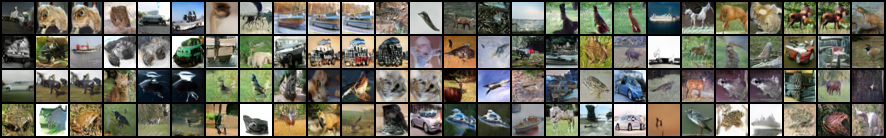

In [47]:
imgs = []
for step in range(xs.shape[0]):
    img = xs[step]
    imgs.append(img)
imgs = torch.stack(imgs, 1).view(-1, 3, 32, 32)
grid = make_grid(imgs, nrow=xs.shape[0])

grid = (255 * grid.permute(1, 2, 0).numpy()).astype('uint8')
Image.fromarray(grid)